In [1]:
!pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.7 MB/s eta 0:00:00


In [15]:
import torch
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.spatial import distance_matrix

# 1. Load Data from CSV
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# 2. Create Graph Data
def create_graph(df, distance_threshold):
    # Node features: Latitude, Longitude, and Population
    node_features = torch.tensor(df[['Latitude', 'Longitude', 'population']].values, dtype=torch.float)

    # Create edge index based on proximity (using a distance matrix)
    coords = df[['Latitude', 'Longitude']].values
    dist_matrix = distance_matrix(coords, coords)

    # Define edges where the distance between nodes is less than the threshold
    edge_index = np.array(np.where((dist_matrix < distance_threshold) & (dist_matrix > 0)))  # Exclude self-loops
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Convert to undirected by adding reverse edges
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1).unique(dim=1)

    # Create the graph data structure
    graph_data = Data(x=node_features, edge_index=edge_index)
    return graph_data

# 3. GNN Model Definition
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First GCN Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second GCN Layer
        x = self.conv2(x, edge_index)

        return x

# 4. Train and Test Data Preparation
train_data = load_data('/content/updated_data_train.csv')
test_data = load_data('/content/updated_data.csv')

# Define a distance threshold for edge creation (e.g., 0.1 degree distance)
distance_threshold = 0.1

# Create graph structures
train_graph = create_graph(train_data, distance_threshold)
test_graph = create_graph(test_data, distance_threshold)

# 5. Training Function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    # Using population as the target
    target = data.x[:, 2]  # Population field is the target

    # Loss function (MSE for regression)
    loss = criterion(out[:, 2], target)
    loss.backward()
    optimizer.step()
    return loss.item()

# 6. Evaluation Function
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        target = data.x[:, 2]  # Population field
        pred = out[:, 2]  # Predicted population
        mse = mean_squared_error(target.numpy(), pred.numpy())
        return mse

# Hyperparameters
input_features = 3  # Latitude, Longitude, Population
hidden_features = 16
output_features = 3  # Output the same features

# Initialize model, optimizer, and loss function
model = GNNModel(in_channels=input_features, hidden_channels=hidden_features, out_channels=output_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    loss = train(model, train_graph, optimizer, criterion)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Evaluation on the test dataset
mse = evaluate(model, test_graph)
print(f'Test Mean Squared Error: {mse}')

Epoch 0, Loss: 3539191296.0
Epoch 10, Loss: 2092633984.0
Epoch 20, Loss: 1409357440.0
Epoch 30, Loss: 1324403712.0
Epoch 40, Loss: 1344763264.0
Epoch 50, Loss: 1315286528.0
Epoch 60, Loss: 1315214336.0
Epoch 70, Loss: 1314520704.0
Epoch 80, Loss: 1313304448.0
Epoch 90, Loss: 1313474176.0
Test Mean Squared Error: 911755264.0


In [3]:
!pip install torch torch-geometric scikit-learn matplotlib

<ipython-input-16-09d5dfc5d4d9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(train_coords[['Latitude', 'Longitude', 'population']])


Epoch 0, Loss: 1.843760371208191
Epoch 100, Loss: 0.006018215790390968
Epoch 200, Loss: 0.0038841809146106243
Epoch 300, Loss: 0.0027747389394789934
Epoch 400, Loss: 0.0021044539753347635
Epoch 500, Loss: 0.0016933315200731158
Epoch 600, Loss: 0.0014312260318547487
Epoch 700, Loss: 0.0012474035611376166
Epoch 800, Loss: 0.0011162285227328539
Epoch 900, Loss: 0.0010162988910451531


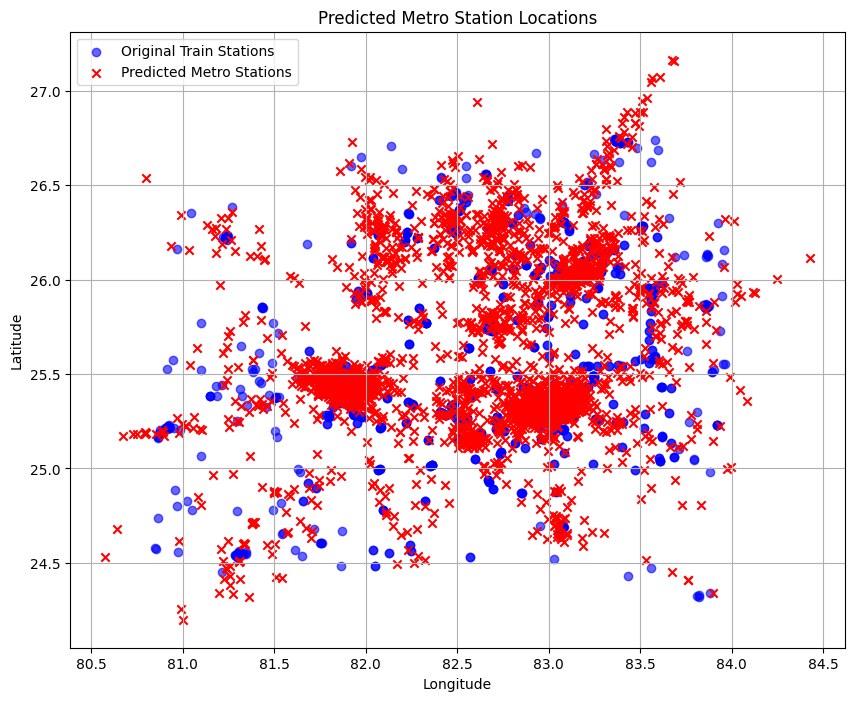

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(train_coords[['Latitude', 'Longitude', 'population']])

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity (n_neighbors=5 for more connections)
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        G.add_edge(i, neighbors[j])

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
for edge in G.edges():
    edge_index.append([edge[0], edge[1]])

# Convert node features and edge index to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Define the GCN model with batch normalization
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)  # Input: 3 features (Lat, Long, Population)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 16)
        self.conv4 = GCNConv(16, 2)  # Output: 2 features (Predicted Lat, Long)
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(16)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = torch.relu(x)

        x = self.conv4(x, edge_index)
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    target = data.x[:, :2]  # Target is Latitude and Longitude (first two features)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform the predictions to original scale
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform Latitude and Longitude predictions
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude and longitude values to stay within valid ranges
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range
predicted_positions[:, 1] = np.clip(predicted_positions[:, 1], -180, 180)  # Longitude range

# Plot original train data and predicted metro station locations
plt.figure(figsize=(10, 8))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Original Train Stations', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations', marker='x')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

Epoch 0, Train Loss: 280.1304016113281, Validation Loss: 267.3974304199219
Epoch 10, Train Loss: 24.199758529663086, Validation Loss: 24.514080047607422
Epoch 20, Train Loss: 3.6099648475646973, Validation Loss: 5.118714809417725
Epoch 30, Train Loss: 1.1871317625045776, Validation Loss: 1.5879958868026733
Epoch 40, Train Loss: 0.5371126532554626, Validation Loss: 0.5086562633514404
Epoch 50, Train Loss: 0.3332441747188568, Validation Loss: 0.30133262276649475
Epoch 60, Train Loss: 0.28037819266319275, Validation Loss: 0.26910272240638733
Epoch 70, Train Loss: 0.23598341643810272, Validation Loss: 0.2285473793745041
Epoch 80, Train Loss: 0.19357213377952576, Validation Loss: 0.17191942036151886
Epoch 90, Train Loss: 0.1810360997915268, Validation Loss: 0.136107936501503
Epoch 100, Train Loss: 0.14782731235027313, Validation Loss: 0.13626821339130402
Epoch 110, Train Loss: 0.1403152197599411, Validation Loss: 0.1340247094631195
Epoch 120, Train Loss: 0.11590617895126343, Validation Loss

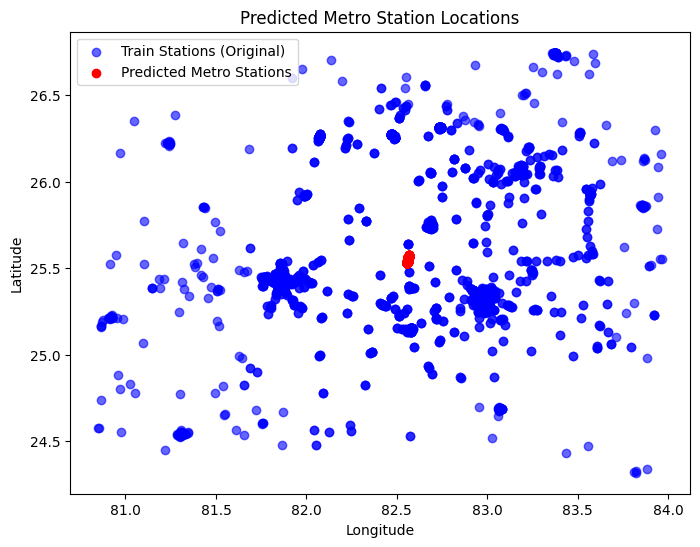

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']].copy()  # Avoid SettingWithCopyWarning

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        distance = distances[i, j]
        population_diff = abs(train_coords['population'].iloc[i] - train_coords['population'].iloc[neighbors[j]])
        weight = 1 / (distance + 1e-5) + population_diff  # Combined proximity and population influence
        G.add_edge(i, neighbors[j], weight=weight)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with edge weights
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 2)
        self.dropout = 0.3

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.dropout(x, p=self.dropout, train=self.training)
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.dropout(x, p=self.dropout, train=self.training)
        x = self.conv3(x, edge_index, edge_weight=edge_weight)
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)

# Split the data into training and validation sets
num_nodes = data.num_nodes
train_mask = torch.randperm(num_nodes)[:int(0.8 * num_nodes)]
val_mask = torch.randperm(num_nodes)[int(0.8 * num_nodes):]

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    target = data.x[:, :2]  # Target is Latitude and Longitude (first two features)
    loss = criterion(out[train_mask], target[train_mask])
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = criterion(out[val_mask], target[val_mask])
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

<ipython-input-6-5f629d5fe8d1>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6931785941123962
Epoch 10, Loss: 0.6929122805595398
Epoch 20, Loss: 0.6925374865531921
Epoch 30, Loss: 0.6920972466468811
Epoch 40, Loss: 0.691841721534729
Epoch 50, Loss: 0.6911342144012451
Epoch 60, Loss: 0.6906699538230896
Epoch 70, Loss: 0.6899161338806152
Epoch 80, Loss: 0.6902294754981995
Epoch 90, Loss: 0.6886082887649536
Epoch 100, Loss: 0.6881477236747742
Epoch 110, Loss: 0.695315957069397
Epoch 120, Loss: 0.6923092007637024
Epoch 130, Loss: 0.6916437149047852
Epoch 140, Loss: 0.6909236311912537
Epoch 150, Loss: 0.6900941133499146
Epoch 160, Loss: 0.6905950903892517
Epoch 170, Loss: 0.6904518008232117
Epoch 180, Loss: 0.6898803114891052
Epoch 190, Loss: 0.691676914691925
Epoch 200, Loss: 0.6904025077819824
Epoch 210, Loss: 0.6897854804992676
Epoch 220, Loss: 0.6882702708244324
Epoch 230, Loss: 0.6889363527297974
Epoch 240, Loss: 0.6874784827232361
Epoch 250, Loss: 0.6873021125793457
Epoch 260, Loss: 0.685795247554779
Epoch 270, Loss: 0.6865265965461731
Epoch 2

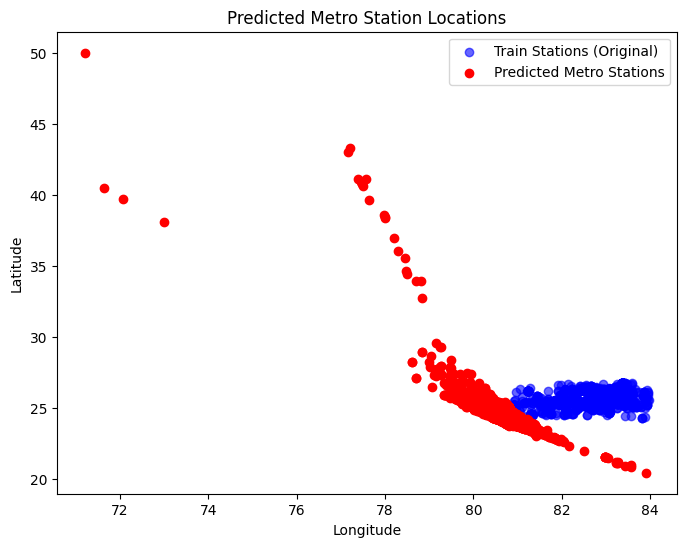

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 2)  # Output: 2 classes (for classification)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = self.conv10(x, edge_index, edge_weight=edge_weight)  # No activation here
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare target classes for cross-entropy (binned latitude/longitude)
# Assuming we have class labels for training; adjust this as needed
num_classes = 2  # Placeholder: Set the actual number of classes based on your use case
target = torch.randint(0, num_classes, (data.num_nodes,))  # Random labels as placeholder

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # Cross-entropy loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-7-81a365738b47>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.31384867429733276
Epoch 10, Loss: 0.06153486296534538
Epoch 20, Loss: 0.04433171823620796
Epoch 30, Loss: 0.03285309672355652
Epoch 40, Loss: 0.025967277586460114
Epoch 50, Loss: 0.02307835966348648
Epoch 60, Loss: 0.02037273906171322
Epoch 70, Loss: 0.019245225936174393
Epoch 80, Loss: 0.014409217983484268
Epoch 90, Loss: 0.010051012970507145
Epoch 100, Loss: 0.007755489554256201
Epoch 110, Loss: 0.005978552624583244
Epoch 120, Loss: 0.004791232291609049
Epoch 130, Loss: 0.003810588037595153
Epoch 140, Loss: 0.0033412333577871323
Epoch 150, Loss: 0.0026940142270177603
Epoch 160, Loss: 0.001931099221110344
Epoch 170, Loss: 0.0018326182616874576
Epoch 180, Loss: 0.0017692104447633028
Epoch 190, Loss: 0.0020711193792521954
Epoch 200, Loss: 0.00154441362246871
Epoch 210, Loss: 0.0013671658234670758
Epoch 220, Loss: 0.0013547766720876098
Epoch 230, Loss: 0.0011679304298013449
Epoch 240, Loss: 0.0010935234604403377
Epoch 250, Loss: 0.001048553385771811
Epoch 260, Loss: 0.00

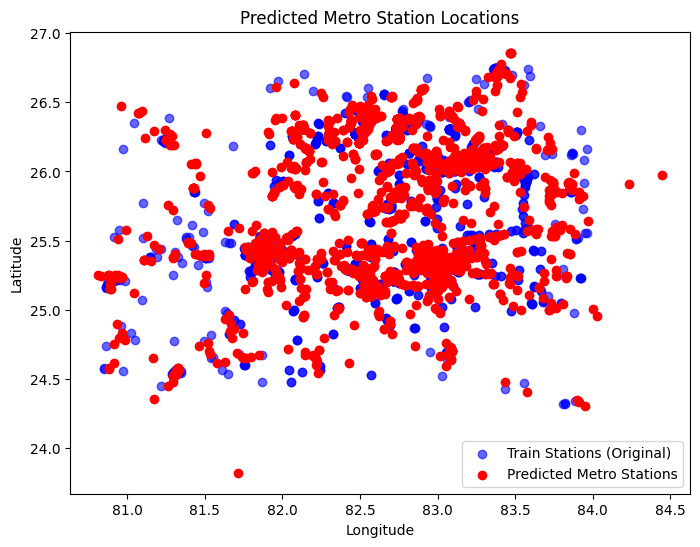

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for regression
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 2)  # Output layer for latitude and longitude (2 continuous values)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = self.conv10(x, edge_index, edge_weight=edge_weight)  # Linear output for regression
        return x

# Initialize the model, MSE loss function, and optimizer
model = GCN()
criterion = nn.MSELoss()  # Use MSE loss for continuous target prediction
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare target coordinates (Latitude and Longitude scaled) as the ground truth for regression
target = torch.tensor(train_coords[['Latitude', 'Longitude']].values, dtype=torch.float)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # MSE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-8-e70a0ecc1b2a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6931500434875488
Epoch 10, Loss: 0.6922932267189026
Epoch 20, Loss: 0.6927880644798279
Epoch 30, Loss: 0.6919503211975098
Epoch 40, Loss: 0.6917141079902649
Epoch 50, Loss: 0.6910008788108826
Epoch 60, Loss: 0.6921311616897583
Epoch 70, Loss: 0.6909631490707397
Epoch 80, Loss: 0.6899168491363525
Epoch 90, Loss: 0.6889953017234802
Epoch 100, Loss: 0.6896300911903381
Epoch 110, Loss: 0.68867427110672
Epoch 120, Loss: 0.6884308457374573
Epoch 130, Loss: 0.6880630850791931
Epoch 140, Loss: 0.6877805590629578
Epoch 150, Loss: 0.6875061392784119
Epoch 160, Loss: 0.6860437393188477
Epoch 170, Loss: 0.6865120530128479
Epoch 180, Loss: 0.6871337890625
Epoch 190, Loss: 0.6866419911384583
Epoch 200, Loss: 0.6851567625999451
Epoch 210, Loss: 0.6855849623680115
Epoch 220, Loss: 0.6842983365058899
Epoch 230, Loss: 0.6828992366790771
Epoch 240, Loss: 0.6915137767791748
Epoch 250, Loss: 0.6902438998222351
Epoch 260, Loss: 0.6894415616989136
Epoch 270, Loss: 0.6876441240310669
Epoch 28

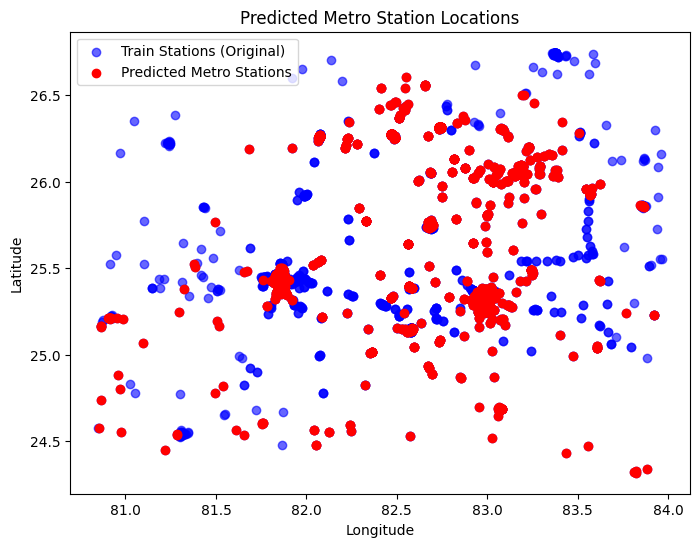

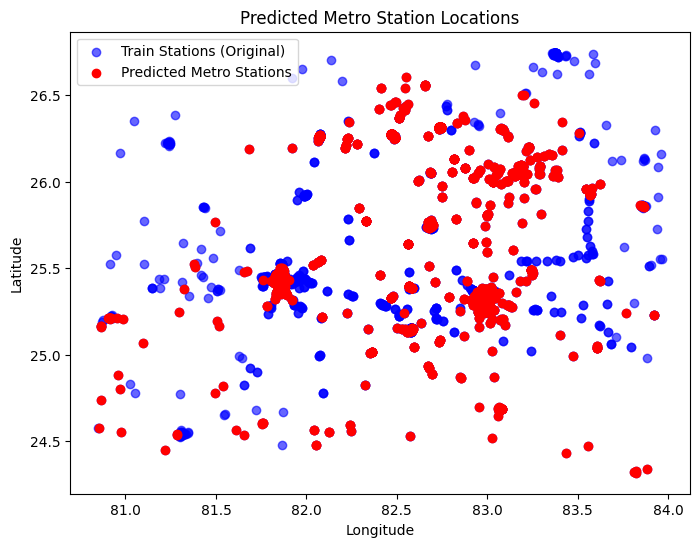

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')


# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
# For demonstration, using random binary labels. Replace with actual binary target labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Obtain predictions and convert them to binary classification
# Post-process: Obtain predictions, apply threshold, and convert back to original latitude/longitude scale
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5 to get binary labels

# Add the binary column for metro station prediction
train_data['Predicted_Metro_Station'] = predicted_labels

# Extract only the latitude and longitude for inverse scaling
predicted_coords = np.zeros((predicted_labels.shape[0], 3))
predicted_coords[:, :2] = train_coords[['Latitude', 'Longitude']].values
predicted_coords[:, 2] = predicted_labels  # Place binary predictions for scaling

# Inverse transform only the coordinates (Latitude and Longitude)
predicted_coords = scaler.inverse_transform(predicted_coords)
predicted_positions = predicted_coords[predicted_coords[:, 2] == 1, :2]  # Select predicted metro stations

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-10-acab4b1de283>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6928609013557434, Accuracy: 51.86%
Epoch 10, Loss: 0.6922881603240967, Accuracy: 51.95%
Epoch 20, Loss: 0.691902220249176, Accuracy: 52.02%
Epoch 30, Loss: 0.6912221312522888, Accuracy: 53.27%
Epoch 40, Loss: 0.6912193894386292, Accuracy: 53.39%
Epoch 50, Loss: 0.6892240643501282, Accuracy: 53.39%
Epoch 60, Loss: 0.6887438893318176, Accuracy: 53.70%
Epoch 70, Loss: 0.687859296798706, Accuracy: 54.13%
Epoch 80, Loss: 0.6870710849761963, Accuracy: 54.25%
Epoch 90, Loss: 0.6866629123687744, Accuracy: 54.66%
Epoch 100, Loss: 0.6857014298439026, Accuracy: 54.51%
Epoch 110, Loss: 0.685256838798523, Accuracy: 55.40%
Epoch 120, Loss: 0.6895317435264587, Accuracy: 54.25%
Epoch 130, Loss: 0.6850184798240662, Accuracy: 55.52%
Epoch 140, Loss: 0.683433473110199, Accuracy: 55.49%
Epoch 150, Loss: 0.6824491024017334, Accuracy: 55.66%
Epoch 160, Loss: 0.6825822591781616, Accuracy: 55.47%
Epoch 170, Loss: 0.6831089854240417, Accuracy: 55.88%
Epoch 180, Loss: 0.6842820644378662, Accura

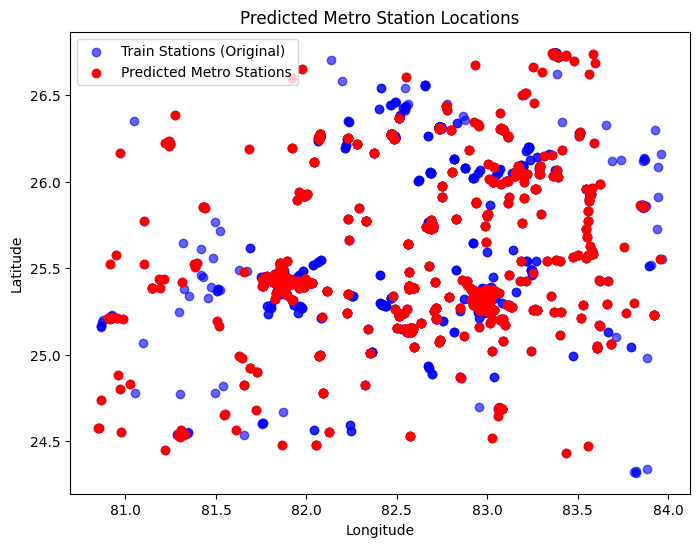

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')


# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])
        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
# For demonstration, using random binary labels. Replace with actual binary target labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model with accuracy tracking
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    with torch.no_grad():
        predicted_labels = (out > 0.5).float()  # Convert probabilities to binary (0 or 1)
        correct = (predicted_labels == target).sum().item()
        accuracy = correct / target.size(0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

# Post-process: Obtain predictions, apply threshold, and convert back to original latitude/longitude scale
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5 to get binary labels

# Add the binary column for metro station prediction
train_data['Predicted_Metro_Station'] = predicted_labels

# Extract only the latitude and longitude for inverse scaling
predicted_coords = np.zeros((predicted_labels.shape[0], 3))
predicted_coords[:, :2] = train_coords[['Latitude', 'Longitude']].values
predicted_coords[:, 2] = predicted_labels  # Place binary predictions for scaling

# Inverse transform only the coordinates (Latitude and Longitude)
predicted_coords = scaler.inverse_transform(predicted_coords)
predicted_positions = predicted_coords[predicted_coords[:, 2] == 1, :2]  # Select predicted metro stations

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


          Amenity Type                                             Name  \
0                  bar                                       mohini bar   
1                  bar                                      The Gem Bar   
2                  bar                                OMG Bar & Kitchen   
3                  bar                                         My Love    
4                  bar                                        Sam's bar   
...                ...                                              ...   
1274  place_of_worship  Dargah Hazrat Baba Rangeele Shah Chisthi Nizami   
1275  place_of_worship                         Sindhi Sat Sangat Darbar   
1276       public_bath                                      Deluxe Bath   
1277       public_bath                                      Deluxe Bath   
1278   public_building                                              NIC   

       Latitude  Longitude                               road  \
0     28.633277  77.223876        

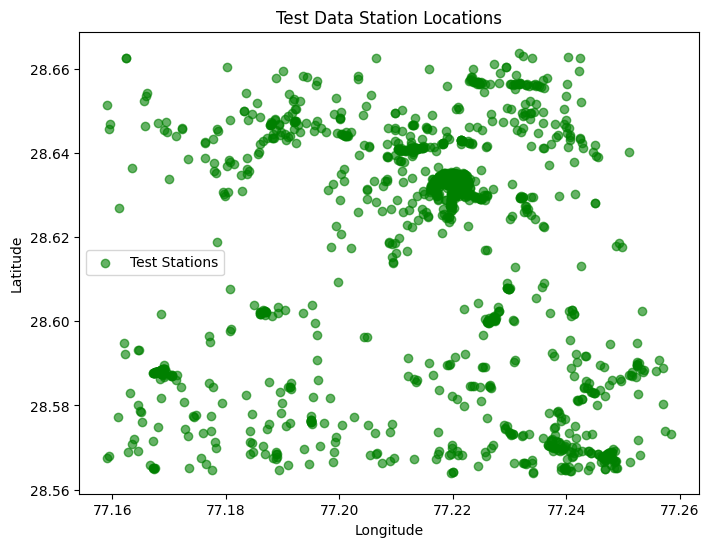

In [11]:
# Load the test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')


print(test_data)
# Extract necessary columns (Latitude, Longitude, Population)
test_coords = test_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude and Longitude using MinMaxScaler (use the same scaler from the training data)
# test_coords[['Latitude', 'Longitude']] = scaler.transform(
#     test_coords[['Latitude', 'Longitude']]
# )

# Plot the original test data
plt.figure(figsize=(8, 6))
plt.scatter(test_coords['Longitude'], test_coords['Latitude'], color='green', label='Test Stations', alpha=0.6)
plt.title('Test Data Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


          Amenity Type                                             Name  \
0                  bar                                       mohini bar   
1                  bar                                      The Gem Bar   
2                  bar                                OMG Bar & Kitchen   
3                  bar                                         My Love    
4                  bar                                        Sam's bar   
...                ...                                              ...   
1274  place_of_worship  Dargah Hazrat Baba Rangeele Shah Chisthi Nizami   
1275  place_of_worship                         Sindhi Sat Sangat Darbar   
1276       public_bath                                      Deluxe Bath   
1277       public_bath                                      Deluxe Bath   
1278   public_building                                              NIC   

       Latitude  Longitude                               road  \
0     28.633277  77.223876        

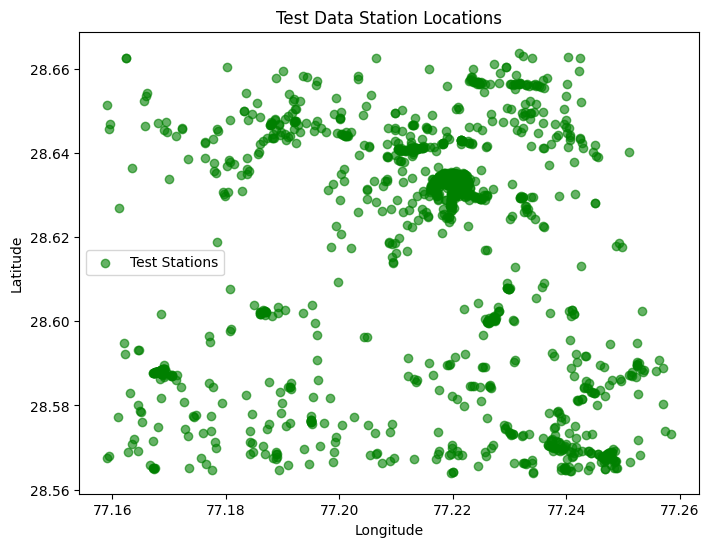

In [12]:
# Load the test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')



print(test_data)
# Extract necessary columns (Latitude, Longitude, Population)
test_coords = test_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude and Longitude using MinMaxScaler (use the same scaler from the training data)
# test_coords[['Latitude', 'Longitude']] = scaler.transform(
#     test_coords[['Latitude', 'Longitude']]
# )

# Plot the original test data
plt.figure(figsize=(8, 6))
plt.scatter(test_coords['Longitude'], test_coords['Latitude'], color='green', label='Test Stations', alpha=0.6)
plt.title('Test Data Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-13-03e87df1ec97>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6929329633712769
Epoch 10, Loss: 0.6929976940155029
Epoch 20, Loss: 0.6927574276924133
Epoch 30, Loss: 0.6923463344573975
Epoch 40, Loss: 0.6918277740478516
Epoch 50, Loss: 0.6913697123527527
Epoch 60, Loss: 0.6920381188392639
Epoch 70, Loss: 0.6907919049263
Epoch 80, Loss: 0.6899223923683167
Epoch 90, Loss: 0.690365731716156
Epoch 100, Loss: 0.6893178820610046
Epoch 110, Loss: 0.6879779696464539
Epoch 120, Loss: 0.687845766544342
Epoch 130, Loss: 0.6868376135826111
Epoch 140, Loss: 0.6891250014305115
Epoch 150, Loss: 0.6905563473701477
Epoch 160, Loss: 0.6887905597686768
Epoch 170, Loss: 0.6898708343505859
Epoch 180, Loss: 0.688041627407074
Epoch 190, Loss: 0.6871150732040405
Epoch 200, Loss: 0.6859083771705627
Epoch 210, Loss: 0.6860204339027405
Epoch 220, Loss: 0.6864699125289917
Epoch 230, Loss: 0.686549723148346
Epoch 240, Loss: 0.6858739256858826
Epoch 250, Loss: 0.6849273443222046
Epoch 260, Loss: 0.6832717061042786
Epoch 270, Loss: 0.6846780180931091
Epoch 280,

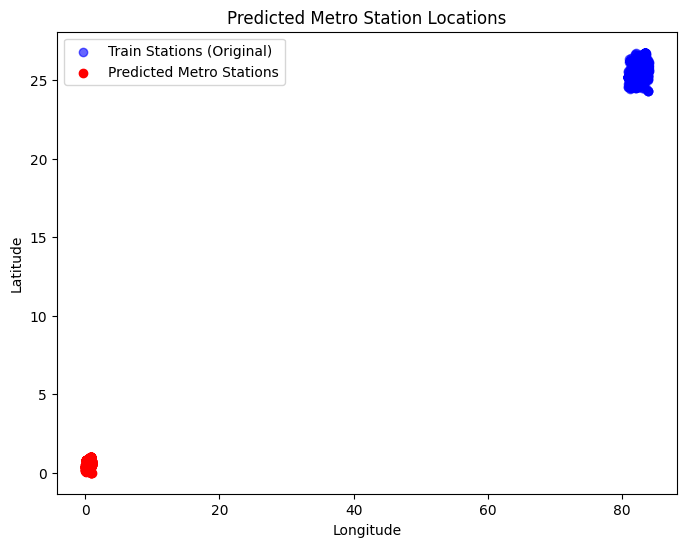

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('/content/updated_data_train.csv')
test_data = pd.read_csv('/content/updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Output layer for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Remove single-dimensional entries from the shape

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare target labels (binary: 1 for metro station, 0 for non-station)
# Example: create random binary labels as a placeholder. Replace with actual labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Obtain predictions
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Binarize probabilities to get labels (0 or 1)

# Plot the original train data and predicted stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
predicted_positions = train_coords[['Longitude', 'Latitude']].iloc[predicted_labels == 1]
plt.scatter(predicted_positions['Longitude'], predicted_positions['Latitude'], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [14]:
import random

# After predicting all the stations:
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Step 1: Randomly select 100 stations from the predicted positions
if predicted_positions.shape[0] > 100:
    sampled_positions = random.sample(predicted_positions.tolist(), 100)
    sampled_positions = np.array(sampled_positions)
else:
    sampled_positions = predicted_positions  # If less than 100 predicted, use all

# Step 2: Plot only the selected 100 stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label='Predicted Metro Stations (100)')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

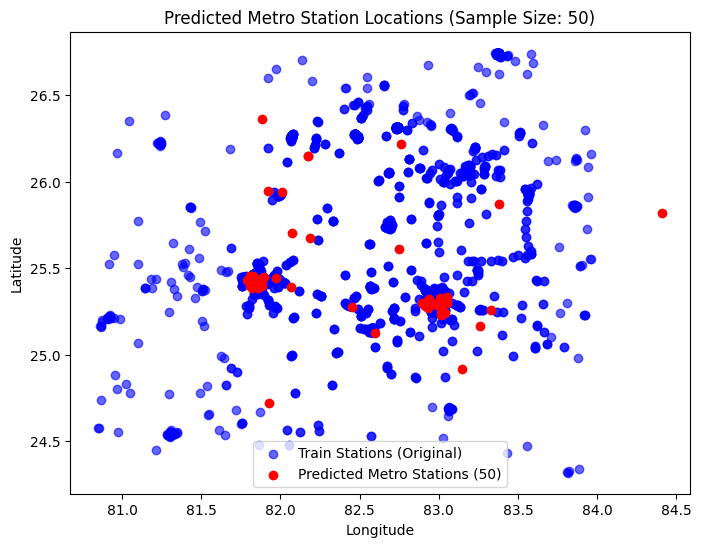

Sample Size: 50, Accuracy Score (MSE): N/A


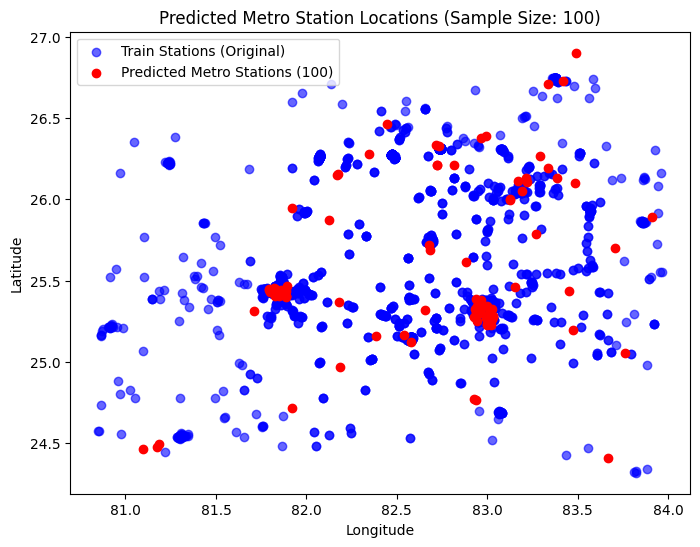

Sample Size: 100, Accuracy Score (MSE): N/A


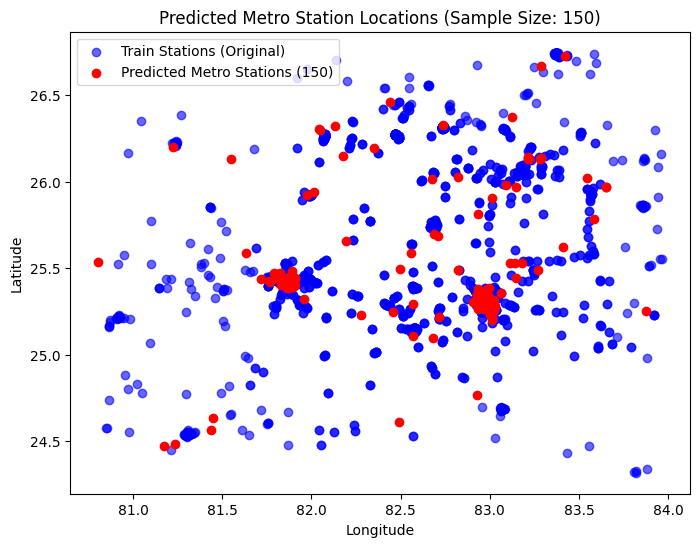

Sample Size: 150, Accuracy Score (MSE): N/A


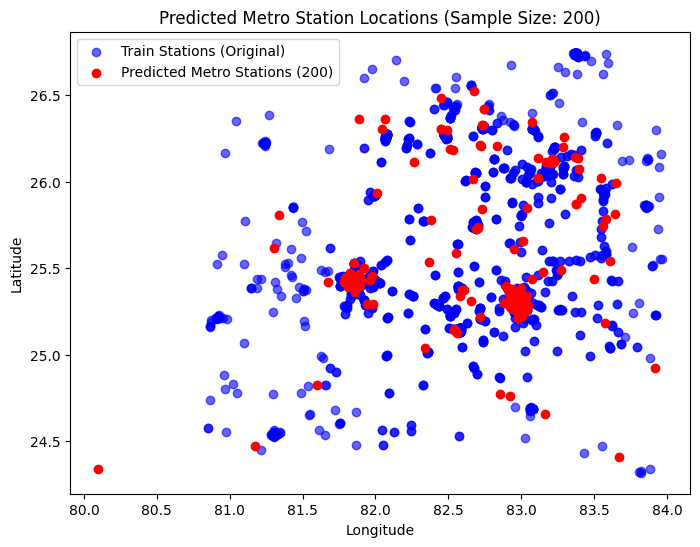

Sample Size: 200, Accuracy Score (MSE): N/A


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume `model`, `scaler`, `data`, and `train_data` are defined and initialized.

# Predict positions
predicted_positions = model(data).detach().numpy()

# Inverse transform predictions for Latitude and Longitude
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip Latitude values to a valid range
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)

# List of different numbers of points to sample for analysis
sample_sizes = [50, 100, 150, 200]  # Example sample sizes

# Loop over each sample size and calculate accuracy
for sample_size in sample_sizes:
    if predicted_positions.shape[0] > sample_size:
        sampled_positions = random.sample(predicted_positions.tolist(), sample_size)
        sampled_positions = np.array(sampled_positions)
    else:
        sampled_positions = predicted_positions  # Use all if fewer than sample size

    # Accuracy Score Calculation (Assuming `true_positions` is defined for comparison)
    # Here, `true_positions` should contain actual Lat and Long values to compare.
    accuracy_score = mean_squared_error(true_positions[:sample_size], sampled_positions) if 'true_positions' in locals() else 'N/A'

    # Plot the selected number of stations
    plt.figure(figsize=(8, 6))
    plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
    plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label=f'Predicted Metro Stations ({sample_size})')
    plt.title(f'Predicted Metro Station Locations (Sample Size: {sample_size})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

    # Print accuracy score
    print(f"Sample Size: {sample_size}, Accuracy Score (MSE): {accuracy_score}")


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume `model`, `scaler`, `data`, `train_data`, and `true_positions` are defined and initialized.

# Predict positions
predicted_positions = model(data).detach().numpy()

# Inverse transform predictions for Latitude and Longitude
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip Latitude values to a valid range
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)

# List of different numbers of points to sample for analysis
sample_sizes = [50, 100, 150, 200]  # Example sample sizes

# Loop over each sample size and calculate accuracy
for sample_size in sample_sizes:
    if predicted_positions.shape[0] > sample_size:
        sampled_indices = random.sample(range(predicted_positions.shape[0]), sample_size)
        sampled_positions = predicted_positions[sampled_indices]
        sampled_true_positions = true_positions[sampled_indices]  # Select corresponding true positions
    else:
        sampled_positions = predicted_positions  # Use all if fewer than sample size
        sampled_true_positions = true_positions  # Use all true positions

    # Calculate accuracy (MSE)
    accuracy_score = mean_squared_error(sampled_true_positions, sampled_positions)

    # Plot the selected number of stations
    plt.figure(figsize=(8, 6))
    plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
    plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label=f'Predicted Metro Stations ({sample_size})')
    plt.title(f'Predicted Metro Station Locations (Sample Size: {sample_size})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

    # Print accuracy score
    print(f"Sample Size: {sample_size}, Accuracy Score (MSE): {accuracy_score}")


NameError: name 'true_positions' is not defined

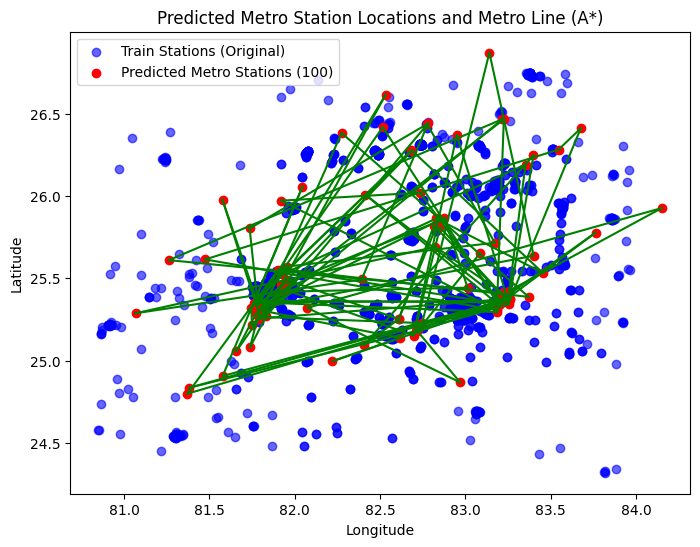

In [ ]:
import heapq
import math

# Heuristic function: Euclidean distance between two nodes
def heuristic(node1, node2):
    return math.sqrt((node1[0] - node2[0]) ** 2 + (node1[1] - node2[1]) ** 2)

# A* algorithm to find the path between two nodes
def astar(start, goal, graph):
    open_list = []
    heapq.heappush(open_list, (0, start))

    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0

    f_score = {node: float('inf') for node in graph}
    f_score[start] = heuristic(start, goal)

    while open_list:
        _, current = heapq.heappop(open_list)

        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Return reversed path

        for neighbor in graph[current]:
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_score[neighbor], neighbor))

    return []  # Return an empty path if no path is found

# Build a graph for A* pathfinding from the selected 100 stations
def build_graph(stations):
    graph = {}
    for i, station1 in enumerate(stations):
        graph[tuple(station1)] = []
        for j, station2 in enumerate(stations):
            if i != j:
                graph[tuple(station1)].append(tuple(station2))
    return graph

# After random selection of 100 stations:
if predicted_positions.shape[0] > 100:
    sampled_positions = random.sample(predicted_positions.tolist(), 100)
    sampled_positions = np.array(sampled_positions)
else:
    sampled_positions = predicted_positions  # If less than 100 predicted, use all

# Step 1: Build the graph from the selected 100 stations
graph = build_graph(sampled_positions)

# Step 2: Connect all stations using A* algorithm and store the paths
metro_lines = []
for i in range(len(sampled_positions) - 1):
    start_station = tuple(sampled_positions[i])
    end_station = tuple(sampled_positions[i + 1])
    path = astar(start_station, end_station, graph)
    metro_lines.append(path)

# Step 3: Plot the metro stations and the A* metro lines
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label='Predicted Metro Stations (100)')

# Plotting metro lines
for path in metro_lines:
    if path:  # Ensure the path is valid
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], color='green',)

plt.title('Predicted Metro Station Locations and Metro Line (A*)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()
